# JupyLabBook @ SIRIUS

In [4]:
# import custom libraries
from lib.extraction.common import PyNexus as PN
from lib.frontend import frontend as FE
from lib.extraction.GIXD import GIXD as GIXD



#import useful libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats, Javascript, display

# necessary for plotting in the notebook
%matplotlib inline

# to avoid having a large notebook
set_matplotlib_formats('png', 'pdf')
    
# to have all the cells expanded (not collapsed)
display(Javascript('IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}'))
        
# define the class experiment
class Experiment:
    """
    Class Experiment is used to pass arguments concerning the current experiment only.
    """
    def __init__(self):
        pass

# test if the expt already exists (avoid loosing info when reloading this cell)
try:
    expt.notebook_name
except:
    expt = Experiment() 

# necessary for saving in pdf
expt.notebook_name = 'JupyLabBook.ipynb'

# directory where the data will be saved
expt.working_dir = "working/"

# directory where the nexus files are 
expt.recording_dir = "recording/"

# directory where the logs are
expt.logs_dir = "logs/"   

<IPython.core.display.Javascript object>

In [2]:
FE.Check_files(expt)

Versions of modules used:
frontend: 2.0
PyNexus: v4.1
Check that you are using the last versions of the modules on: 
https://github.com/ArnaudHemmerle/JupyLabBook



<IPython.core.display.Javascript object>

### SIRIUS_2020_03_12_0756: continuous_ascan delta -24 -19 100 5

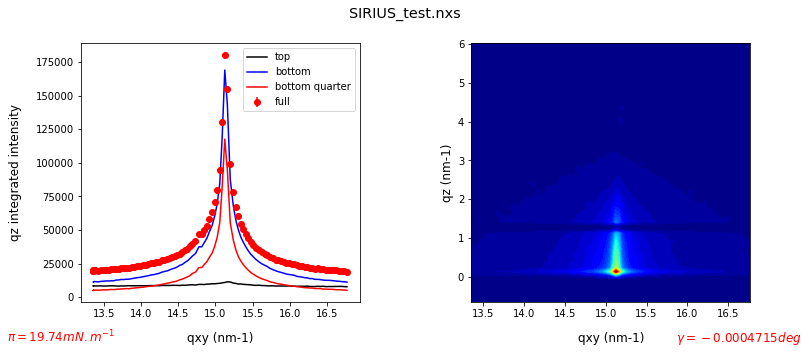

In [6]:
x, y, xlabel, ylabel, column_x,\
daty, datyTop, datyBottom, datyFirstQuarter,\
mat, mat_binned, ch_binned, \
mean_pi, mean_area, mean_gamma = \
GIXD.Extract(nxs_filename='SIRIUS_2020_03_12_0756.nxs', recording_dir=expt.recording_dir,
             channel0=607, thetazfactor=0.00024318628377198605, wavelength=0.155, thetac=0.0028,
             binsize=10, computeqz=True,
             show_data_stamps=False, verbose=False,absorbers='')


GIXD.Plot(x=x, y=y, xlabel=xlabel, ylabel=ylabel, 
          daty=daty, datyTop=datyTop, datyBottom=datyBottom, datyFirstQuarter=datyFirstQuarter,
          mat=mat, mat_binned=mat_binned, ch_binned=ch_binned,
          mean_pi=mean_pi, mean_area=mean_area, mean_gamma=mean_gamma,
          nxs_filename='SIRIUS_test.nxs', logx=False, logy=False, logz=False,
          nblevels=50, absorbers='', cmap='jet')


GIXD.Save(x=x, daty=daty, datyTop=datyTop, datyBottom=datyBottom, datyFirstQuarter=datyFirstQuarter, mat=mat, moytocreate=[10, 20, 40], mean_gamma=mean_gamma, column_x=column_x,
          channel0=607, thetazfactor=0.00024318628377198605, wavelength=0.155, thetac=0.0028,
         nxs_filename='SIRIUS_2020_03_12_0756.nxs', recording_dir=expt.recording_dir, working_dir=expt.working_dir,
         computeqz=True, verbose=False)


In [ ]:
CF.Extract_GIXD(nxs_filename='SIRIUS_2020_03_12_0756.nxs',working_dir=expt.working_dir, recording_dir=expt.recording_dir, logx=False,logy=False,logz=False,channel0=607.0,thetazfactor=0.00024318628377198605,wavelength=0.155,thetac=0.0028,binsize=10,computeqz=True,nblevels=50,moytocreate=[10, 20, 40],show_data_stamps=False,verbose=False,absorbers='29 - Vide',cmap='jet')

In [3]:
FE.Choose_action(expt)

interactive(children=(SelectMultiple(description='nxs_files', options=('SIRIUS_Isotherm_2019_02_17_01544.nxs',…